# PHYS20762 - Project 3 - Simulation of thermal neutrons

Ramón Ciutad Pérez<br>
University of Manchester  
May 2022


# Abstract

The aim of this project is to learn about random methods. To do this, we will experiment with random number generators to construct several types of distributions (uniform, exponential, three-dimensional, etc). Also, these methods will be applied to a simulation of a beam of neutrons incident normally on a slab. Making use of the mean free path (a statistical concept that will be explained later) we will analyze how many neutrons are reflected off the slab, how many are absorbed in it and how many are transmitted through it. Finally, we will test an alternative method known as the Woodcock method to carry out the same simulation as well as more complex ones.

# Basic Theory about collisions and mean free path

First, we must start off by defining the mean free path $\lambda$. This is the distance that on average a particle will travel before encountering another particle (obstacle). The latter can either absorb or scatter the former. For a quantitative analysis of $\lambda$ one must consider a small volume element which encloses all obstacles that the original particle will collide with. This volume is a cylinder with base $\sigma$ (cross-sectional area) and length $dx$. Therefore, the number of collisions after traveling distance $dx$ is:

$ dN = - N n \sigma dx $ ,

where $N$ is the number of non-absorbed particles and $n$ is the number density of obstacles in the medium. Integrating we find:

$ N(x) = N_0 \exp(-n \sigma x) = N_0 \exp(-\frac{x}{\lambda})$ .

Here we have defined the mean free path $\lambda$ as $\frac{1}{n \sigma}$ . 

In other words, the probability of a single particle travelling a distance $x$ is:

$ P(x) = \exp(-\frac{x}{\lambda}) $

However, reality is more complex and as mentioned before, not all particles that undergo a collisions will be absorbed. Some of them will be scattered. These particles will travel in a different direction and we will have to consider again the rate of collisions to work out how far they will travel before having another encounter. In most cases, the effective cross-section is no the same for scattering processes as it is for absorptions. In the case of having two different corss-sectional areas we have to consider the macroscopic cross-section $\Sigma$, which is defined as:

$\Sigma = n \sigma$ .

Because we have two different processes, the total macroscopic cross-section will be the sum of the two individual cross-sections:

$\Sigma_{total} = \Sigma_{absorb} + \Sigma_{scatter} =  n (\sigma_{absorb} + \sigma_{scatter})$ ,

In the last expression we have taken a common factor of $n$ because the same particles are responsible for absorption and scattering (same number density).

The new mean free path will be:

$\lambda = \frac{1}{\Sigma_{total}}$

Now, every time a collision between a particle and an obstacle, we do not know if there is going to be scattering or absorption. We solve this by defining the probabilities of scattering and absorption such that:

$ P_{absorb} = \frac{\Sigma_{absorb}}{\Sigma_{total}} $ ;     $ P_{scatter} = \frac{\Sigma_{scatter}}{\Sigma_{total}} $

# Section 1: Studying Random Number Generators

We first start by initializing our Python interpreter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

We also define some variables that will be useful later

In [2]:
# All units are in cgs system
# For water:
density_water = 1
particle_mass_water = 18.015*1.66e-24
sigma_absorb_water = 0.6652*1.13e-24
sigma_scatter_water = 103.0*1.13e-24

# For lead:
density_lead = 11.35
particle_mass_lead = 207.2*1.66e-24
sigma_absorb_lead = 0.158*1.13e-24
sigma_scatter_lead = 11.221*1.13e-24

# For graphite:
density_graphite = 1.67
particle_mass_graphite = 12.011*1.66e-24
sigma_absorb_graphite = 0.0045*1.13e-24
sigma_scatter_graphite = 4.74*1.13e-24

# Uniform Distribution

In this section we will study the behavior of the numpy function $numpy.random.uniform()$, which generates a certain amount of random numbers between 0 and 1. We firstly want to check that it is truly random (actually pseudo-random), by plotting a histogram of the generated numbers and check that it is distributed in a random manner. We will test this by generating an increasing amount of numbers.

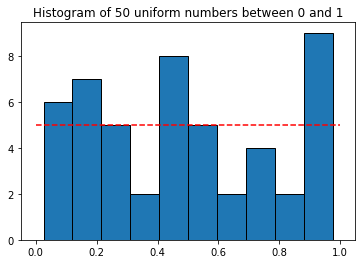

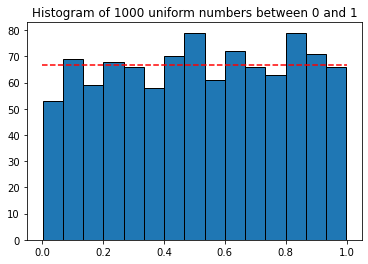

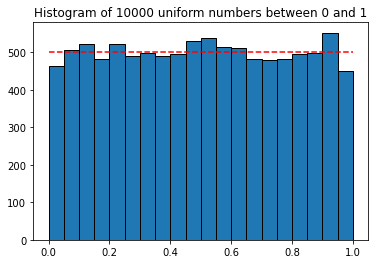

In [3]:
def uniform_generator(n_numbers, n_bins):
    array = np.random.uniform(size=n_numbers) # Generate random numbers
    expected_average = n_numbers/n_bins # Calculate expected average
    
    # Plot histogram and expected average
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Histogram of {} uniform numbers between 0 and 1'.format(n_numbers))
    ax.hist(array, bins=n_bins, edgecolor='black')
    ax.plot([0,1], [expected_average, expected_average], '--', c='r')
    plt.show()
    
    return None

# Repeat for several amounts of random numbers
uniform_generator(50, 10)
uniform_generator(1000, 15)
uniform_generator(10000, 20)

As it can be observed in the graphs above, as the number of generated numbers increases, relative random fluctuations become weaker. This results in most of the bins being very approaching the expected average (marked with a red dashed line) as the quantity of generated numbers increases (as predicted by the law of large numbers).

We will now make sure that this function is (almost) truly random by plotting a cube in three dimensions and checking by eye that the generated points do indeed look arbitrary and do not hold any correlation between each other.

<IPython.core.display.Javascript object>


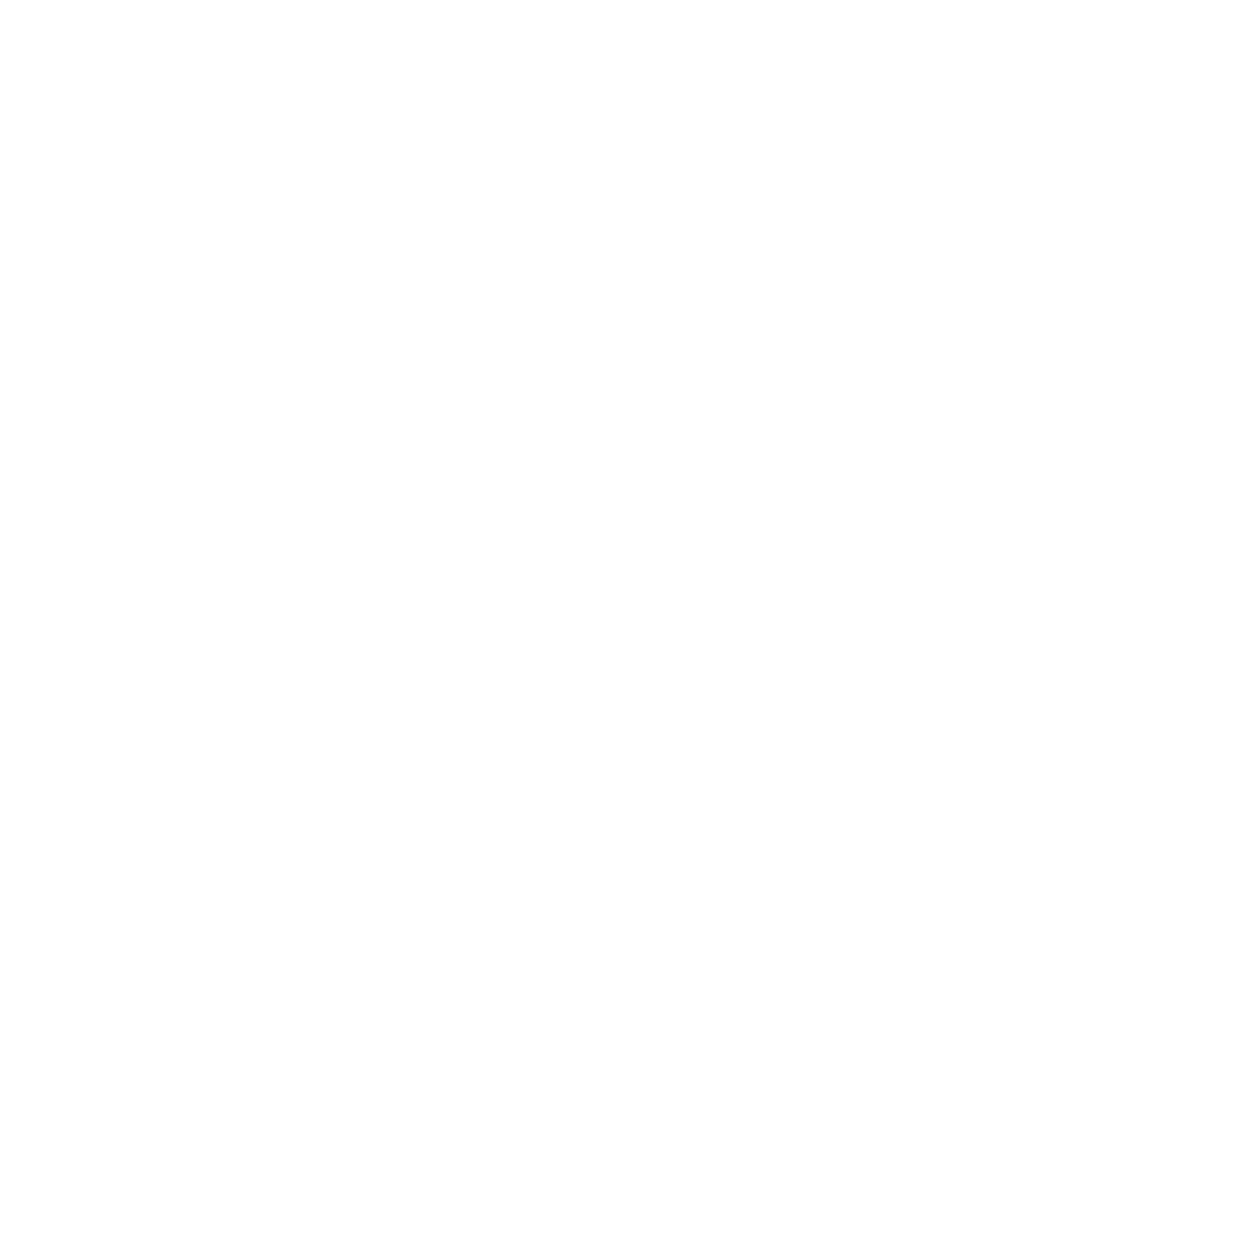

In [4]:
get_ipython().magic('matplotlib notebook')


def plot_3D(x, y, z):
    """
    This function will be used throughout the report to generate 3D plots. It takes as input 3 arrays of points corresponding
    to the x, y and z coordinates of the points and shows them on the graph.

    """
    fig = plt.figure(figsize=(10, 10)) # Create extra large figure
    ax = Axes3D(fig) # Set 3D axes
    ax.scatter(x, y, z, color='r') # Scatter the datapoints
    # Set the axes' labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    
    return None

def generate_3D_random_cube(n_numbers):
    # Generate random x, y and z coordinates between 0 and 1
    x_array = np.random.uniform(size=n_numbers)
    y_array = np.random.uniform(size=n_numbers)
    z_array = np.random.uniform(size=n_numbers)
    
    plot_3D(x_array, y_array, z_array) # Plot datapoints
    
    return None

generate_3D_random_cube(3000)

As we can see, independently of the perspective we look at the cube from, it 'looks very random', and the points seem to be uniformly distributed across the volume of the cube. From this we can conclude that the $numpy.random.uniform()$ works rpoperly and can be used for the rest of the report.

In contrast with this method, to show what 'randomly generated points' must not look like, will will generate another cube with the same volume but usiing a different method. This method is called a Linear Congruential Generator (LCG), and it works making use of the following formula:

$ X_{n+1} = (a X_n + c) \mod m $ ,

where mod is the modulus operator, which gives the remainder of $ (a X_n + c) $ divided by $m$; and $a$, $c$ and $m$ are integers.

We will use this method to generate datapoints and plot them in 3 dimensions:

<IPython.core.display.Javascript object>


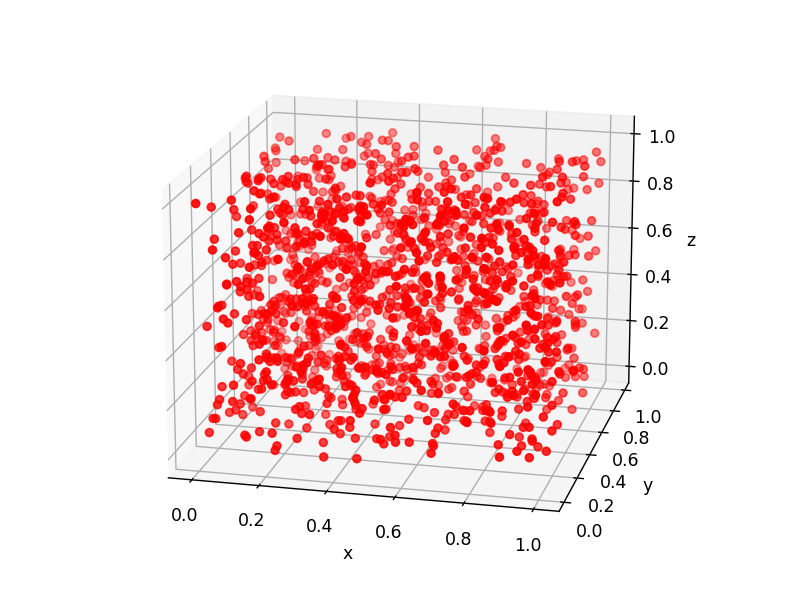

In [5]:
import numpy as np
 
#  RANDSSP Multiplicative congruential uniform random number generator.
#  Based on the parameters used by IBM's Scientific Subroutine Package.
#  The statement
#     r = randssp(m,n)
#  generates an m-by-n random matrix.
#  The function can not accept any other starting seed.
#
#  This function uses the "bad" generator parameters that IBM
#  used in several libraries in the 1960's.  There is a strong
#  serial correlation between three consecutive values.

def randssp(p,q):
    
    global m, a, c, x
        
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r


# In[214]:


k = randssp(3, 1500)


# In[215]:


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

get_ipython().magic('matplotlib notebook')
#using instead of %matplotlib inline for rotation

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(k[0, :], k[1, :], k[2, :], color='r')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

As one turns the plot around, it can be very clearly seen that the generated points are not uniformly distributed, but reside in parallel planes. This is because the LCG is not flawless and generates numbers for the x, y and z coordinates which are correlated. Therefore, since we are going to be working in three dimensions, we will discard this method to generate numbers, because we a uniform distribution of probability.

# Exponential Distribution

Now we are going to apply $numpy.random.uniform()$ to a exponential distribution $\exp(-\frac{x}{\lambda})$. To do this, we will generate a random distance according to the following equation:

$ s_i = -\lambda  \ln(u_i) $ ,  where $s_i$ is the distance and $u_i$ is a random number between 0 and 1. 

This ensures that the probability for a ceratin distance to be generated follows a decaying exponential. If we plot a histogram of the counts againts distance it should have an exponential shape as explained above.

If we then take a the logarithm of the counts, it will behave linearly, and thus we can fit a straight line through it. From this we can calculate the resulting $\lambda$ and its error (from error propagation).

For example, we can test this method by inputting $\lambda = 45$ cm, which is the mean free path in water.

<IPython.core.display.Javascript object>


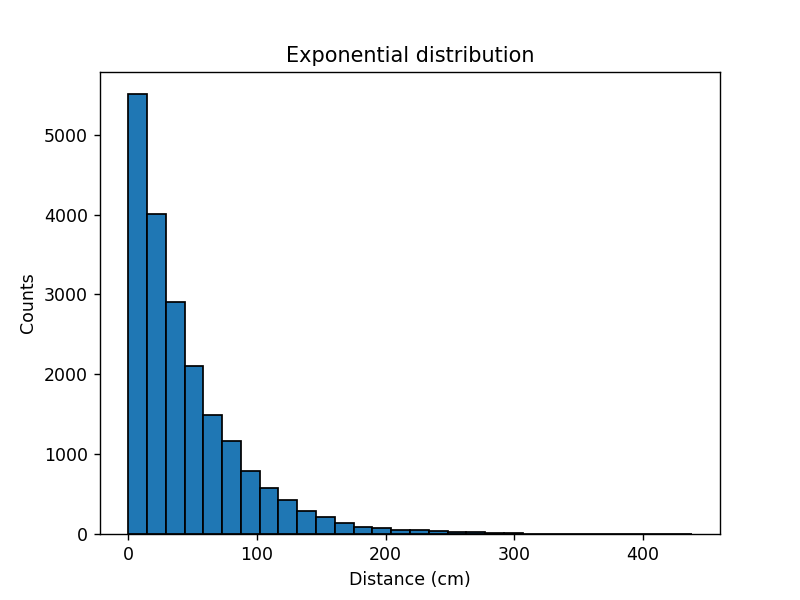

<IPython.core.display.Javascript object>


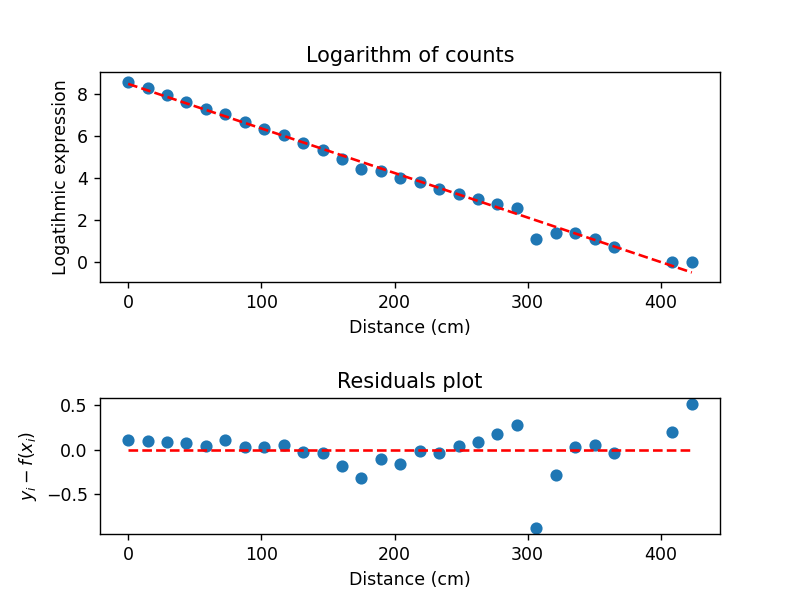

Calculated attenuatuion length from randomly generated points: (46.95 +- 0.82) cm
This means that the calculated value is 2.36 sigma away from 45cm


In [6]:
def exponential_distribution(n_numbers, n_bins, mfp, plot=True):
    # Generate positions which have a exponentially decaying probability from random numbers between 0 and 1 
    s_array = -mfp*np.log(np.random.uniform(size = n_numbers)) 
    
    if plot: 
        # If we want a plot, then fit a straight line through the data and calculate lambda from the fir parameters

        # Create 1st plot
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.set_title('Exponential distribution')
        ax1.set_xlabel('Distance (cm)')
        ax1.set_ylabel('Counts')
        counts, distance, _ = ax1.hist(s_array, bins=n_bins, edgecolor='black')
        plt.show()

        # Eliminate bins with zero counts 
        distance = distance[np.argwhere(counts != 0)]
        counts = counts[np.argwhere(counts != 0)]
        log_vals = np.log(counts) # Compute logarithm
        (coef, covr) = np.polyfit(distance[:,0], log_vals, deg=1, cov=True) # Fit straight line and get parameters and their errors
        slope = coef[0]
        sigma_slope = np.sqrt(covr[0][0])
        residuals = log_vals - np.polyval(coef, distance)
        y_fit = np.polyval(coef, np.linspace(distance[:,0][0], distance[:,0][-1], 2))

        # Create 2nd plot
        fig2 = plt.figure()
        ax2 = fig2.add_subplot(211)
        ax2.set_title('Logarithm of counts')
        ax2.set_xlabel('Distance (cm)')
        ax2.set_ylabel('Logatihmic expression')
        ax2.scatter(distance[:,0], log_vals[:,0], label='generated log points')
        ax2.plot([distance[:,0][0], distance[:,0][-1]], y_fit, '--', c='r', label='linear fit function')
        ax3 = fig2.add_subplot(313)
        ax3.set_title('Residuals plot')
        ax3.set_xlabel('Distance (cm)')
        ax3.set_ylabel(r'$ y_i - f(x_i) $')
        ax3.scatter(distance[:,0], residuals[:,0])
        ax3.plot([distance[:,0][0], distance[:,0][-1]], [0, 0], '--', c='r')
        plt.show()

        # Calculate mean free path and its error
        mpf_fit = -1/slope
        mpf_fit_error = sigma_slope/(slope**2)

        return mpf_fit[0], mpf_fit_error[0]
    
    else:
        return s_array

# Using lambda equal to 45 cm 
mpf_calculated, sigma_mpf = exponential_distribution(20000, 30, 45)
print('Calculated attenuatuion length from randomly generated points: ({0:3.2f} +- {1:3.2f}) cm'.format(mpf_calculated, sigma_mpf))
print('This means that the calculated value is {:3.2f} sigma away from 45cm'.format(abs(mpf_calculated - 45)/sigma_mpf))

This function gives a good value of the calculated mean free path when comparing it to the input theoretical value of $45$ cm. However, most of the times this function returns a value around 1 and 2 sigma away from the actual value, which might be indicative that error propagation is underestimating the uncertainties on the calculated mean free path.

Continuing exploring uniformly distributed numbers, we will plot a 3D spherical surface. We need it to be uniformly populated by datapoints since this is how we are going to generate the direction of travel of a scattered neutron.

To generate this sphere, one possible method is to first generate an x-coordinate between 0 and 1, then a y-coordinate between 0 and $\sqrt{1- x^2}$ and finally a z-coordinate between 0 and $\sqrt{1- x^2 - y^2}$. This is shown below:

<IPython.core.display.Javascript object>


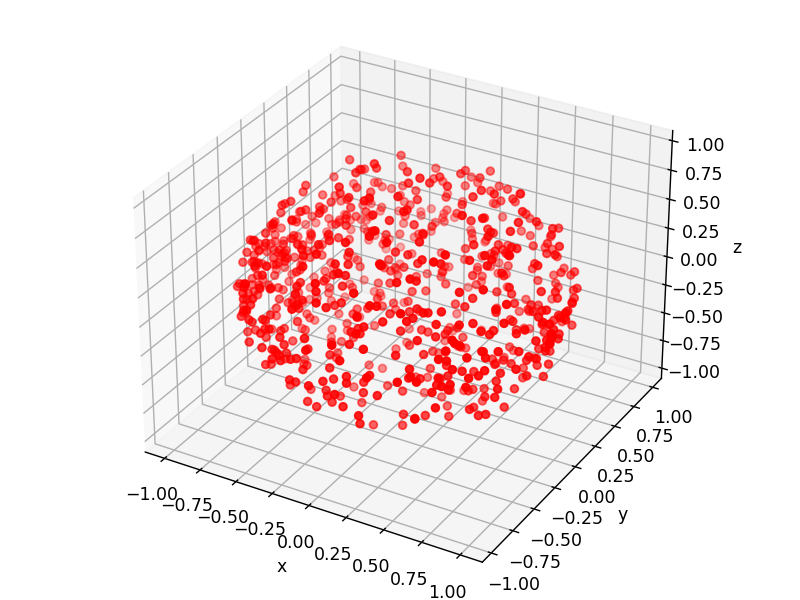

In [7]:
def flawed_spherical_shell(n_numbers):
    # Generate x, y and z coordinates as discussed above
    x_random_array = np.random.uniform(low=-1, high=1, size=n_numbers)
    y_random_array = np.random.uniform(low=-np.sqrt(1-x_random_array**2), high=np.sqrt(1-x_random_array**2), size=n_numbers)
    z_random_array = np.random.uniform(low=-np.sqrt(1-x_random_array**2-y_random_array**2), high=np.sqrt(1-x_random_array**2-y_random_array**2), size=n_numbers)
    
    # Scatter plot of generated points
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x_random_array, y_random_array, z_random_array, color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    
    return None

flawed_spherical_shell(750)

As seen above this method is very flawed. This is because there is a significant bias towards the poles in the x-axis that makes the points have a higher concentration around $x = 0$ and $x = 1$ than around $z = 0$ and $z = 1$.

To solve this, we use an alternative method that involves spherical coordinates:

<IPython.core.display.Javascript object>


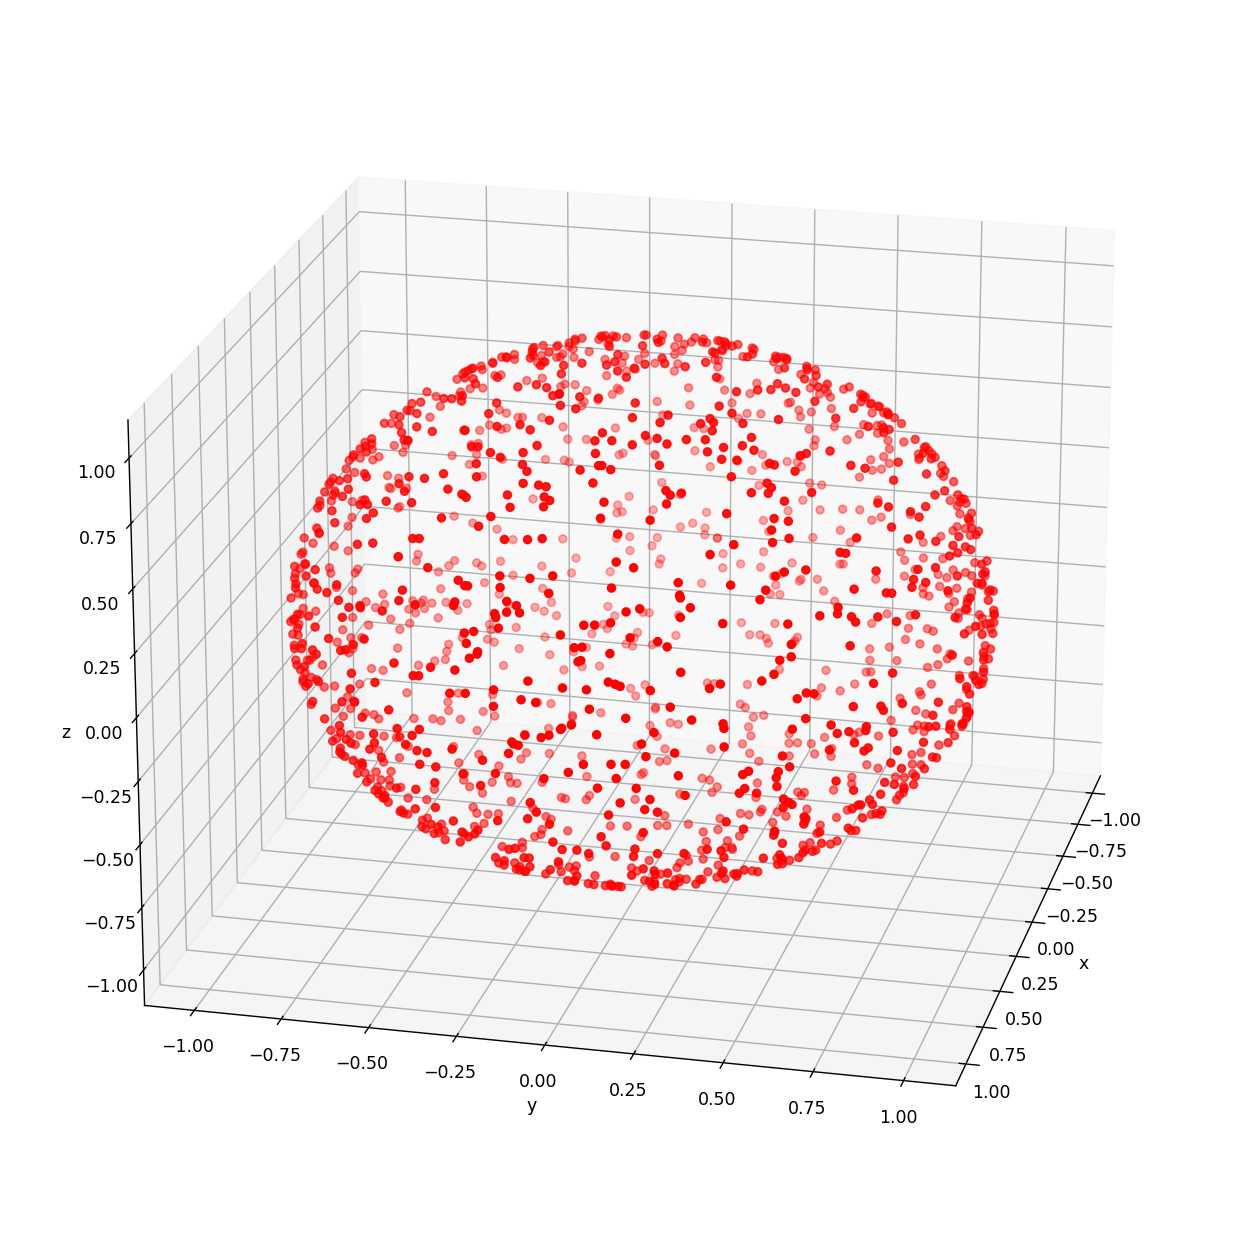

In [8]:
def random_spherical_shell(n_numbers, mfp, random_radius=True, plot=False, cartesian_output=True):
    # Create arrays of random uniform numbers for theta and phi (in spherical polar coordinates)
    theta_array = np.arccos(1 - 2*np.random.uniform(size=n_numbers)) # Use this method to avoid any bias
    phi_array = 2*np.pi*np.random.uniform(size=n_numbers)
    # If we want a randomly generated radius, we generate one that falls exponentially
    if random_radius: 
        radius = exponential_distribution(n_numbers, 0, mfp, plot=False)
    # Otherwise, we set it equal to 1
    else:
        radius = 1
    # Transform from spherical polar to cartesian coordinates
    x_array = radius*np.sin(theta_array)*np.cos(phi_array)
    y_array = radius*np.sin(theta_array)*np.sin(phi_array)
    z_array = radius*np.cos(theta_array)
    
    if plot:
        plot_3D(x_array, y_array, z_array)
    
    if cartesian_output:
        return x_array, y_array, z_array
   
    else:
        return radius, theta_array, phi_array

_ = random_spherical_shell(1500, 0, random_radius=False, plot=True)

Now, we want to generate isotropic stepts distributed as $\exp(-\frac{x}{\lambda})$ . These will represent the steps the scattered neutrons will take. To do so, we use previously defined function but now with randomly generated radii. We use water's value of the mean free path as an example:

<IPython.core.display.Javascript object>


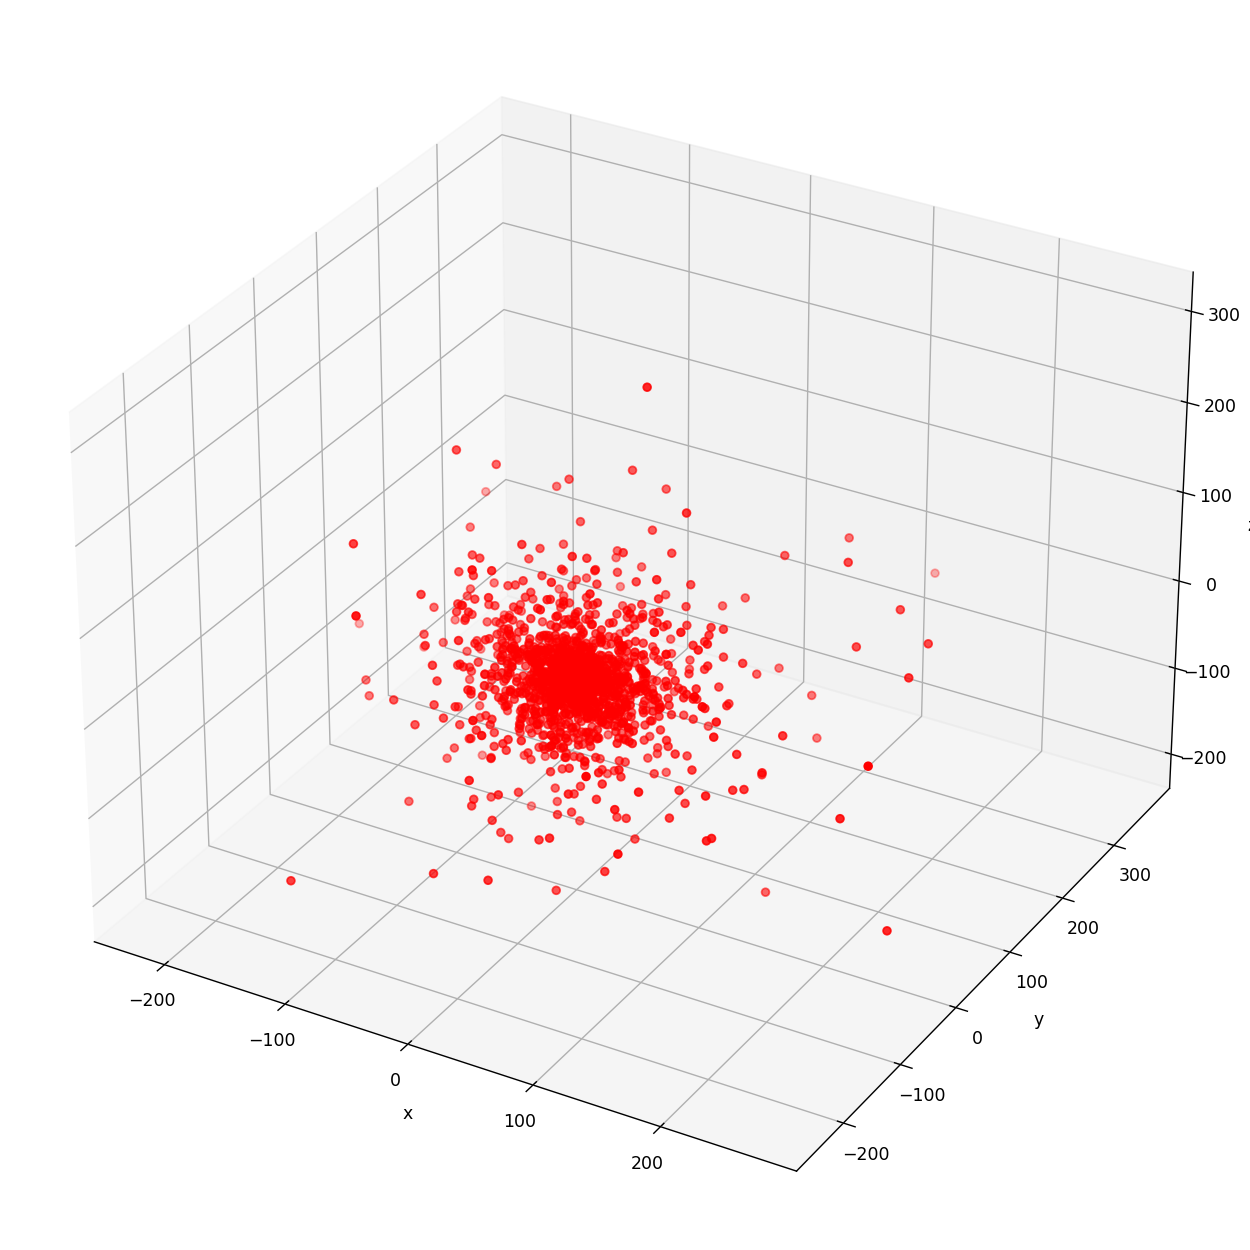

In [9]:
_ = random_spherical_shell(2000, 45, plot=True) # Plot 2000 points of isotropic random steps in water

As expected, the dots are isotropically distributed with respect to the origin (0,0,0) and the distance from it falls exponentially.

# Section 2: Simulation of a Beam of Neutrons through a Slab

Here we make use of all the previously defined functions to run a simulation of beam of neutrons incident normally to a slab of a certain material.

As discussed in theory section, the particle can be either absorbed or scattered. To determine which process takes place, a random number is generated between 0 and 1. Is the number is smaller than $ P_{absorb}$, the neutron is absorbed; otherwise it is scattered and takes a new step.

Firstly, we start by defining and using a very simple function that shows the trajectory of a neutron inside of the slab that can be absorbed or scattered. For plotting purposes, the simulation is set to finish after 20 steps or after the particle is absorbed. The results are the following:

<IPython.core.display.Javascript object>


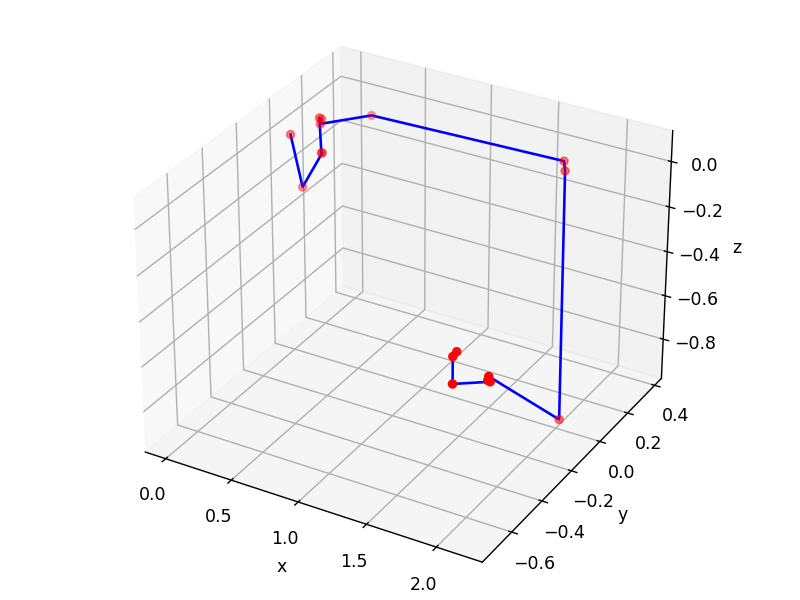

In [20]:
def one_step_simulation(x, y, z, mfp, prob_absorb):
    i = np.random.uniform()
    if i <= prob_absorb:
        return True
    else:
        delta_x, delta_y, delta_z = random_spherical_shell(1, mfp)
        return False, [(x+delta_x), (y+delta_y), (z+delta_z)]

def one_particle_simulation_plot():
    # For water:
    density = 1
    particle_mass = 18.02 * 1.66e-24
    number_density = density / particle_mass
    sigma_total = number_density * (0.6652 + 103.0) * 1e-24
    mfp = 1/sigma_total
    prob_absorb = number_density * 0.6652e-24 / sigma_total
    
    (x, y, z) = (0, 0, 0)
    x_positions = np.array([x])
    y_positions = np.array([y])
    z_positions = np.array([z])
    i = 1
    counter = 0
    
    while i >= prob_absorb and counter < 21:
        delta_x, delta_y, delta_z = random_spherical_shell(1, mfp)
        x = x + delta_x[0]
        y = y + delta_y[0]
        z = z + delta_z[0]
        x_positions = np.append(x_positions, x)
        y_positions = np.append(y_positions, y)
        z_positions = np.append(z_positions, z)
        i = np.random.uniform()
        counter += 1
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x_positions, y_positions, z_positions, color='r')
    ax.plot(x_positions, y_positions, z_positions, color='b')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    
    return None

one_particle_simulation_plot()

This is what will be 'taking place' inside of the slab in our simulations. Note that, as expected, all directions of scatter seem to be equally likely and short steps are more common than long steps.

Now we run a bigger simulation that follows the same principles and procedure, but it considers 10000 incoming neutrons traveling in the positive x-direction. For this reason, the first step from the wall of the slab is not isotropic, but in the positive x-direction (though it still follows an exponential distribution).

In [11]:
def simulation_with_slab(n_particles, density, particle_mass, sigma_absorb, sigma_scatter, thickness=10):
    # Define parameters that are needed to find steps and to determine if the neutron is absorbed
    number_density = density / particle_mass
    sigma_total = number_density * (sigma_absorb + sigma_scatter)
    mfp = 1/ sigma_total
    prob_absorb = number_density * sigma_absorb / sigma_total
    
    # Define counters
    counter_step = 0
    counter_absorbed = 0
    counter_reflected = 0
    counter_transmitted = 0
    
    # Create array of the positions of each neutron at any given moment
    x_positions = np.zeros(n_particles)
    y_positions = np.zeros(n_particles)
    z_positions = np.zeros(n_particles)

    while len(x_positions) > 0: # While there are still neutrons inside of the slab
        if counter_step == 0: # First step
            delta_x = exponential_distribution(n_particles, 0, mfp, plot=False)
            x_positions += delta_x
            counter_step += 1
            
        else: # Rest of the steps
            delta_x, delta_y, delta_z = random_spherical_shell(len(x_positions), mfp) # New step for all remaining neutrons
            x_positions += delta_x
            y_positions += delta_y
            z_positions += delta_z
        
        # Remove reflected neutrons and increase the counter
        reflected_indeces = np.argwhere(x_positions < 0)
        counter_reflected += len(reflected_indeces)
        x_positions = np.delete(x_positions, reflected_indeces)
        y_positions = np.delete(y_positions, reflected_indeces)
        z_positions = np.delete(z_positions, reflected_indeces)

        # Remove transmitted neutrons and increase the counter
        transmitted_indeces = np.argwhere(x_positions > thickness)
        counter_transmitted += len(transmitted_indeces)
        x_positions = np.delete(x_positions, transmitted_indeces)
        y_positions = np.delete(y_positions, transmitted_indeces)
        z_positions = np.delete(z_positions, transmitted_indeces)

        # Remove absorbed neutrons and increase the counter
        absorb_random_prob_array = np.random.uniform(size=len(x_positions))
        absorbed_indeces = np.argwhere(absorb_random_prob_array < prob_absorb)
        counter_absorbed += len(absorbed_indeces)
        x_positions = np.delete(x_positions, absorbed_indeces)
        y_positions = np.delete(y_positions, absorbed_indeces)
        z_positions = np.delete(z_positions, absorbed_indeces)
            
        counter_step += 1
            
    return counter_absorbed, counter_reflected, counter_transmitted, counter_step

# For water as an exmaple:
absorbed, reflected, transmitted, x_iterations = simulation_with_slab(10000, density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water)


print('Absorbed neutrons =', absorbed)
print('Reflected neutrons =', reflected)
print('Transmitted neutrons =', transmitted)


print('Process completed in {} iterations'.format(x_iterations))

Absorbed neutrons = 1943
Reflected neutrons = 8040
Transmitted neutrons = 17
Process completed in 791 iterations


The above result corresponds to the number of absorbed, reflected and transmitted neutrons through a 10 cm thick slab made out of water. For the rest of the report, all slabs will be taken to have this same thickness.

Now we run this simulation 5 times for each material, taking the final values as the mean and the uncertainty as the sample standard deviation of the registered values.

For water:
Absorbed neutrons: (20.07 +- 0.66)%
Reflected neutrons: (79.77 +- 0.66)%
Transmitted neutrons: (0.16 +- 0.05)%


<IPython.core.display.Javascript object>


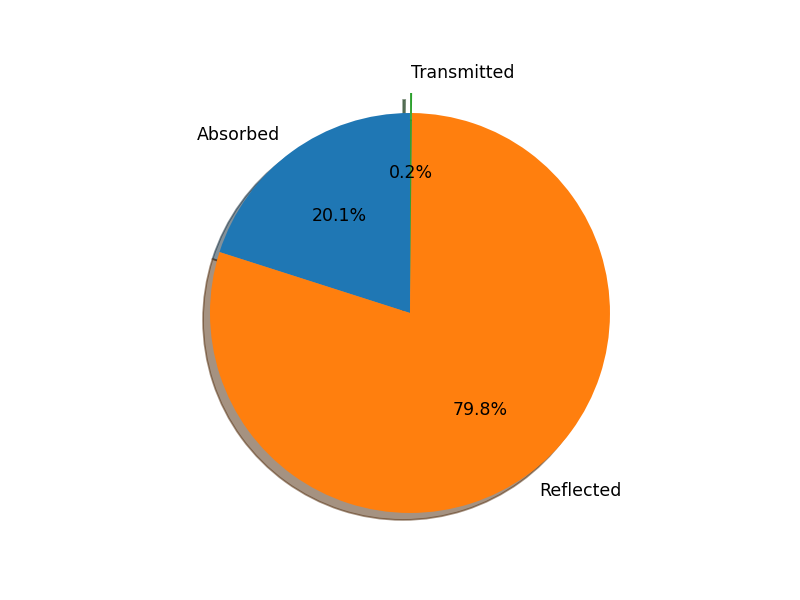

For lead:
Absorbed neutrons: (11.19 +- 0.27)%
Reflected neutrons: (63.73 +- 0.38)%
Transmitted neutrons: (25.08 +- 0.34)%


<IPython.core.display.Javascript object>


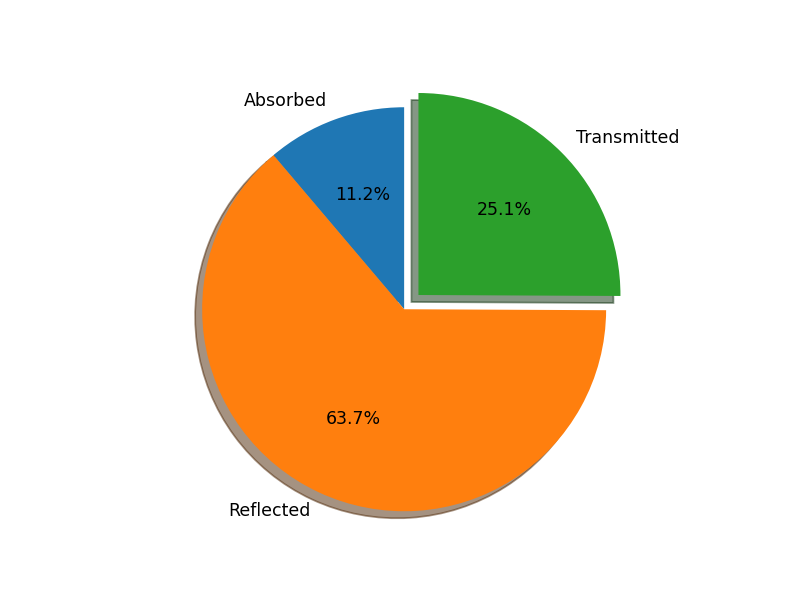

For graphite:
Absorbed neutrons: (0.95 +- 0.11)%
Reflected neutrons: (70.70 +- 0.55)%
Transmitted neutrons: (28.36 +- 0.48)%


<IPython.core.display.Javascript object>


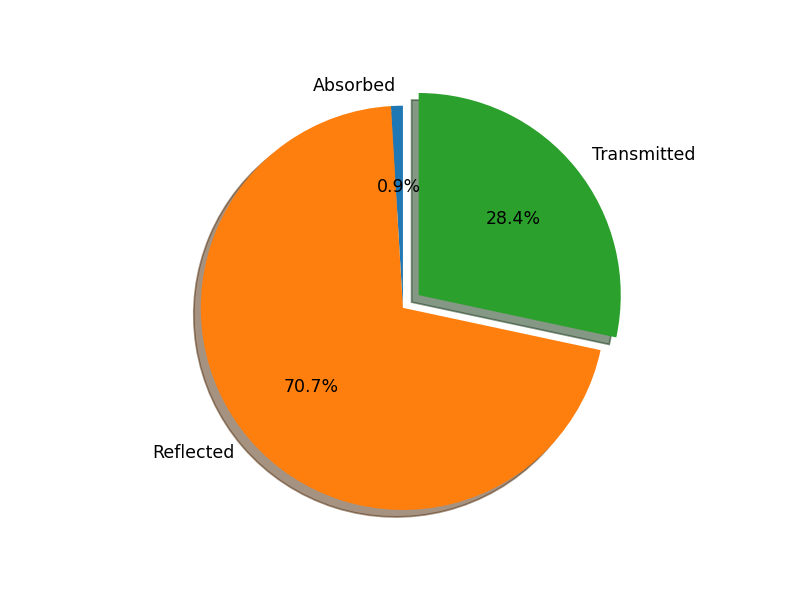

In [12]:
def slab_results():
    # Create lists of parameters that will be used for each material
    parameters_water = [density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water]
    parameters_lead = [density_lead, particle_mass_lead, sigma_absorb_lead, sigma_scatter_lead]
    parameters_graphite = [density_graphite, particle_mass_graphite, sigma_absorb_graphite, sigma_scatter_graphite]
    parameters_list = [parameters_water, parameters_lead, parameters_graphite]
    names_list = ['water', 'lead', 'graphite']
    
    for i in range(3): # Repeat loop for each element
        absorbed_array = np.array([])
        reflected_array = np.array([])
        transmitted_array = np.array([])
        
        # Get 5 values of absorbed, reflected and transmitted neutrons
        for j in range(5):
            absorbed, reflected, transmitted, x_iterations = simulation_with_slab(10000, parameters_list[i][0], parameters_list[i][1], parameters_list[i][2], parameters_list[i][3])
            absorbed_array = np.append(absorbed_array, absorbed)
            reflected_array = np.append(reflected_array, reflected)
            transmitted_array = np.append(transmitted_array, transmitted)
        
        # Take averages as final values and sample standard deviations as uncertainties
        absorbed_value = np.mean(absorbed_array)
        absorbed_error = np.sqrt(np.sum((absorbed_value - absorbed_array)**2 / (len(absorbed_array) - 1)))
        reflected_value = np.mean(reflected_array)
        reflected_error = np.sqrt(np.sum((reflected_value - reflected_array)**2 / (len(reflected_array) - 1)))
        transmitted_value = np.mean(transmitted_array)
        transmitted_error = np.sqrt(np.sum((transmitted_value - transmitted_array)**2 / (len(transmitted_array) - 1)))
        
        print('For {}:'.format(names_list[i]))
        print('Absorbed neutrons: ({0:3.2f} +- {1:3.2f})%'.format(absorbed_value/100, absorbed_error/100))
        print('Reflected neutrons: ({0:3.2f} +- {1:3.2f})%'.format(reflected_value/100, reflected_error/100))
        print('Transmitted neutrons: ({0:3.2f} +- {1:3.2f})%'.format(transmitted_value/100, transmitted_error/100))

        # Plot pie chart of the absorbed, reflected and transmitted neutrons
        fig = plt.figure()
        ax = fig.add_subplot(111)
        labels = 'Absorbed', 'Reflected', 'Transmitted'
        sizes = [absorbed_value, reflected_value, transmitted_value]
        explode = (0, 0, 0.1)
        ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.    


slab_results()

The above results show the percentages of absorbed, reflected and transmitted neutrons for water, lead and graphite. These results are in agreement with what we expected. This is because water has the lowest mean free path out of all three materials and thus neutrons are very unlikely to make it through the entirety of the slab. The opposite could be said about graphite, which has the largest mean free path. Moreover, note how because the $\sigma_{absorb}$ of graphite is 2 orders of magnitude smaller than $\sigma_{scatter}$, there are very few absorbed neutrons. 

We now proceed to produce plots of the absorbed, reflected and scattered neutrons as well as the slab:

<IPython.core.display.Javascript object>


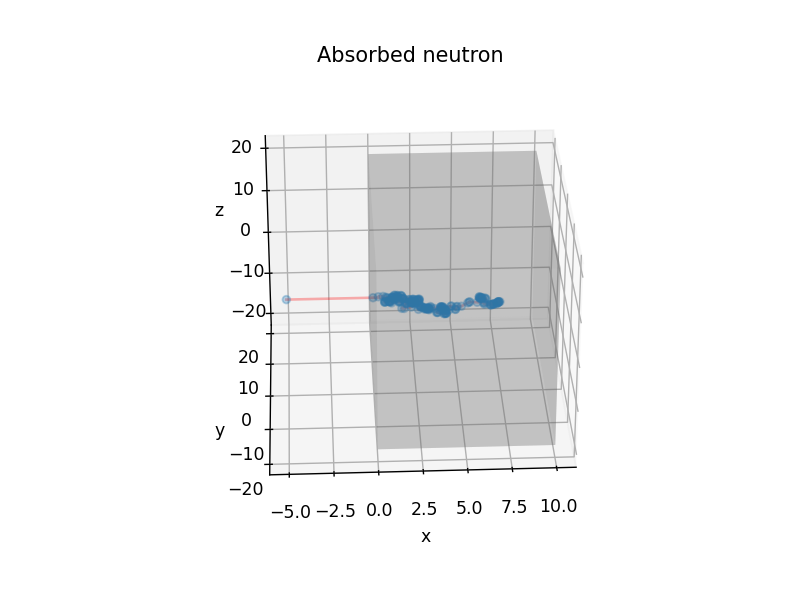

<IPython.core.display.Javascript object>


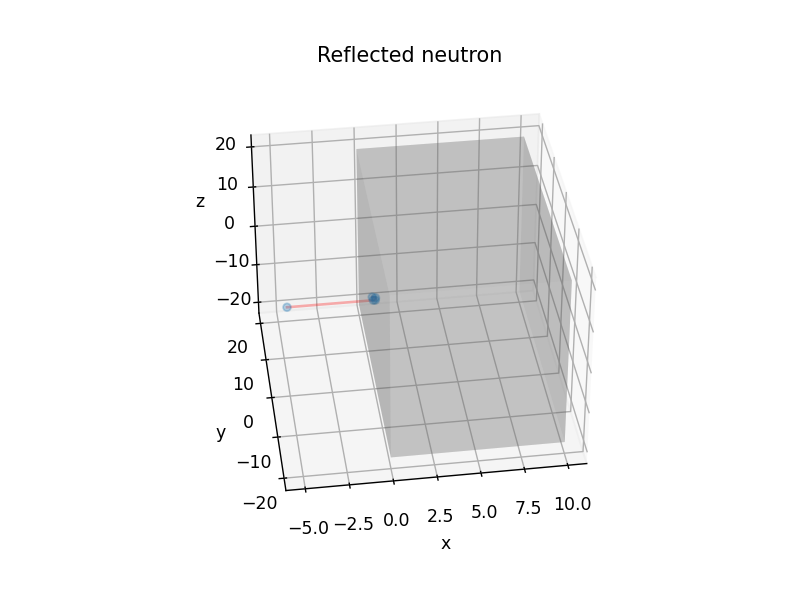

<IPython.core.display.Javascript object>


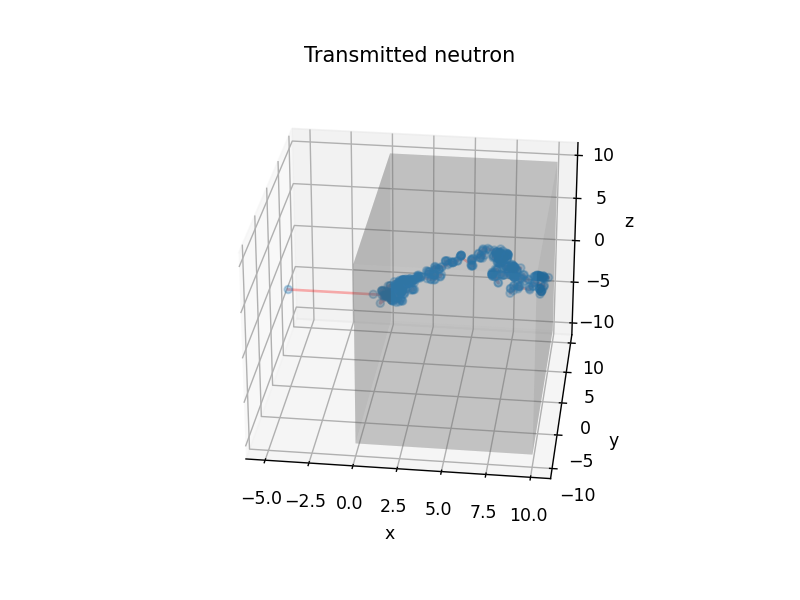

In [13]:
def plot_slab(x_range, y_range, z_range, opacity, desired_color, existing_figure=False, input_fig=0, input_ax=0):
    if not existing_figure:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    
    else:
        fig = input_fig
        ax = input_ax
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    X, Y = np.meshgrid(x_range, y_range)
    Z = np.ones((2,2))
    Z = Z * z_range[0]
    ax.plot_surface(X, Y, Z, alpha=opacity, color=desired_color)
    Z = np.ones((2,2))
    Z = Z*z_range[-1]
    ax.plot_surface(X, Y, Z, alpha=opacity, color=desired_color)

    X, Z = np.meshgrid(x_range, z_range)
    Y = np.ones((2,2))
    Y = Y * y_range[0]
    ax.plot_surface(X, Y, Z, alpha=opacity, color=desired_color)
    Y = np.ones((2,2))
    Y = Y * y_range[-1]
    ax.plot_surface(X, Y, Z, alpha=opacity, color=desired_color)

    Y, Z = np.meshgrid(y_range, z_range)
    X = np.ones((2,2))
    X = X * x_range[0]
    ax.plot_surface(X, Y, Z, alpha=opacity, color=desired_color)
    X = np.ones((2,2))
    X = X * x_range[-1]
    ax.plot_surface(X, Y, Z, alpha=opacity, color=desired_color)
    
    return fig, ax

def register_positions(density, particle_mass, sigma_absorb, sigma_scatter):
    number_density = density / particle_mass
    sigma_total = number_density * (sigma_absorb + sigma_scatter)
    mfp = 1/ sigma_total
    prob_absorb = number_density * sigma_absorb / sigma_total
    
    positions = np.zeros((2, 3)) # Matrix where the coordinates are going to be registered
    positions[0, 0] = -5 # For plotting purpposes we set the neutron coming from x = -5 cm
    positions_copy = positions # Since we are going to be changing the array 'positions', we need a copy of it
    register_absorbed = True
    register_reflected = True
    register_transmitted = True
    counter_step = 0
    
    while register_absorbed or register_reflected or register_transmitted:
        if counter_step == 0:
            delta_x = exponential_distribution(1, 0, mfp, plot=False)[0]
            new_positions = positions[-1, :] + np.array([delta_x, 0, 0])
            positions = np.vstack((positions, new_positions))
            counter_step += 1
    
        else:
            delta_x, delta_y, delta_z = random_spherical_shell(1, mfp)
            new_positions = positions[-1, :] + np.array([delta_x[0], delta_y[0], delta_z[0]])
            positions = np.vstack((positions, new_positions))
            counter_step += 1
        
        if positions[-1, 0] < 0:
            if register_reflected:
                positions_reflected = positions # Create array with the positions of the reflected neutron
                register_reflected = False # Change the value of register_reflected to False because we already have
                                           # registered the positions of a reflected neutron
            
            positions = positions_copy # We set the positions array to the itinital one
            counter_step = 0 # We consider a new particle from the beginning
        
        if positions[-1, 0] > 10:
            if register_transmitted:
                positions_transmitted = positions # Create array with the positions of the transmitted neutron
                register_transmitted = False # Change the value of register_transmitted to False because we already have
                                             # registered the positions of a transmitted neutron
        
            positions = positions_copy # We set the positions array to the itinital one
            counter_step = 0 # We consider a new particle from the beginning
        
        random_number = np.random.uniform()
        if random_number < prob_absorb and positions[-1, 0] > 0 and positions[-1, 0] < 10:
            if register_absorbed:
                positions_absorbed = positions # Create array with the positions of the absorbed neutron
                register_absorbed = False # Change the value of register_absorbed to False because we already have
                                          # registered the positions of a absorbed neutron
           
            positions = positions_copy # We set the positions array to the itinital one
            counter_step = 0 # We consider a new particle from the beginning
    
    return positions_absorbed, positions_reflected, positions_transmitted

def plot_particle_trajectory(density, particle_mass, sigma_absorb, sigma_scatter):
    positions_absorbed, positions_reflected, positions_transmitted = register_positions(density, particle_mass, sigma_absorb,
                                                                                        sigma_scatter)
    fig_absorbed, ax1 = plot_slab(np.array([0, 10]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'grey')
    ax1.scatter(positions_absorbed[:, 0], positions_absorbed[:, 1], positions_absorbed[:, 2], alpha=0.3)
    ax1.plot(positions_absorbed[:, 0], positions_absorbed[:, 1], positions_absorbed[:, 2], alpha=0.3, c='red')
    ax1.set_title('Absorbed neutron')
    
    fig_reflected, ax2 = plot_slab(np.array([0, 10]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'grey')
    ax2.scatter(positions_reflected[:, 0], positions_reflected[:, 1], positions_reflected[:, 2], alpha=0.3)
    ax2.plot(positions_reflected[:, 0], positions_reflected[:, 1], positions_reflected[:, 2], alpha=0.3, c='red')
    ax2.set_title('Reflected neutron')
    
    fig_transmitted, ax3 = plot_slab(np.array([0, 10]), np.array([-10, 10]), np.array([-10, 10]), 0.2, 'grey')
    ax3.scatter(positions_transmitted[:, 0], positions_transmitted[:, 1], positions_transmitted[:, 2], alpha=0.3)
    ax3.plot(positions_transmitted[:, 0], positions_transmitted[:, 1], positions_transmitted[:, 2], alpha=0.3, c='red')
    ax3.set_title('Transmitted neutron')
    
# For plotting purposes, we plot the case for water:
plot_particle_trajectory(density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water)

If we run this simulation many times we can see that most of the reflected neutrons do not make very far into the slab. On the other hand, the transmitted neutrons have a very long and convoluted path.

Next, we can use the above function to register the number of transmitted neutrons for a range of thicknesses of the slab. The error on the counts are computed from the standrad deviation of 3 samples. Fitting a straight line through the logarithm of the counts one can find the attenuation length (which cannot be calculated analytically and corresponds to -1 divided by the slope of the fit). THe procedure here is very similar to the one followed before with the decayin exponential distribution.

The below example is for water:

<IPython.core.display.Javascript object>


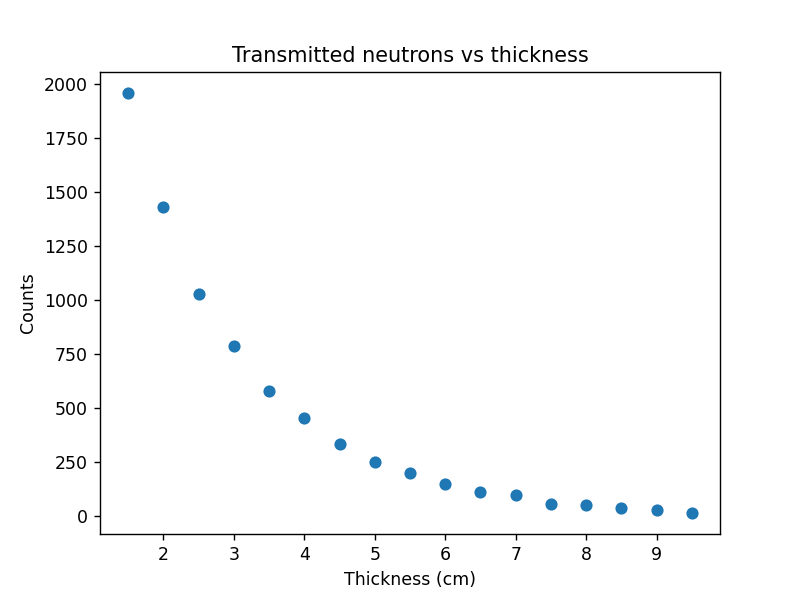

<IPython.core.display.Javascript object>


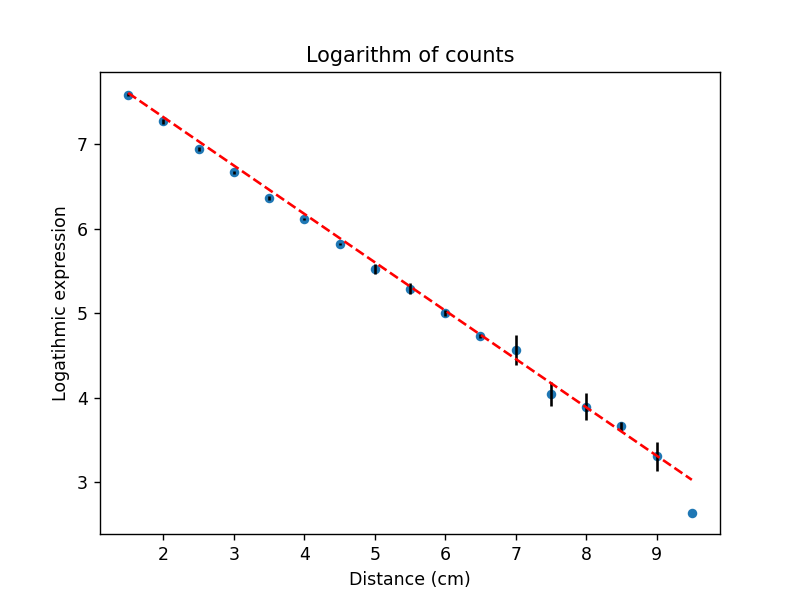

In [14]:
def varying_thickness(density, particle_mass, sigma_absorb, sigma_scatter, plots=False):
    thickness_array = np.arange(1.5, 10, 0.5)
    transmitted_array = np.array([])
    transmitted_error = np.array([])
    
    for thickness_value in thickness_array:
        values_array = np.array([]) # Create an array that will allow us to register different values of transmitted neutrons to calculate the uncertainty
        for i in range(3):
            absorbed, reflected, transmitted, x_iterations = simulation_with_slab(10000, density, particle_mass, sigma_absorb, sigma_scatter, thickness=thickness_value)
            values_array = np.append(values_array, transmitted) # Append values of each trial
        transmitted_array = np.append(transmitted_array, np.mean(values_array)) # Take the mean value as the number of transmitted neutrons for a given thickness
        std = np.sqrt(np.sum((values_array - transmitted_array[-1])**2 / 2)) # Take the sample standard deviation as the error on the number of transmitted neutrons
        transmitted_error = np.append(transmitted_error, std) 
    
    log_vals = np.log(transmitted_array) # Compute logarithm
    error_log = transmitted_error / transmitted_array # Compute oncertainty on log using error propagation
    
    (coef, covr) = np.polyfit(thickness_array, log_vals, deg=1, w=error_log, cov=True) # Fit straight line using 1/error as the weights
    slope = coef[0]
    sigma_slope = np.sqrt(covr[0][0])
    
    if plots:
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        ax1.set_title('Transmitted neutrons vs thickness')
        ax1.set_xlabel('Thickness (cm)')
        ax1.set_ylabel('Counts')
        ax1.scatter(thickness_array, transmitted_array)
        plt.show()
        
        y_fit = np.polyval(coef, thickness_array)
        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111)
        ax2.set_title('Logarithm of counts')
        ax2.set_xlabel('Distance (cm)')
        ax2.set_ylabel('Logatihmic expression')
        ax2.scatter(thickness_array, log_vals, s=20, label='generated log points')
        ax2.plot(thickness_array, y_fit, '--', c='r', label='linear fit function')
        ax2.errorbar(thickness_array, log_vals, yerr=error_log, ls='none', c='black')
        plt.show()
        
    termination_length = -1/slope # Calculate attenuation or termination length from the fit slope
    error_on_length = sigma_slope/(slope**2)

    return termination_length, error_on_length

attenuation_length_water, sigma_length_water = varying_thickness(density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water, plots=True)

In [15]:
# Print previously obtained results for water
print('Attenuation length for water: ({0:3.2f} +- {1:3.2f}) cm'.format(attenuation_length_water, sigma_length_water))

# Obtain and print results for lead
attenuation_length_lead, sigma_length_lead = varying_thickness(density_lead, particle_mass_lead, sigma_absorb_lead, sigma_scatter_lead)
print('Attenuation length for lead: ({0:3.2f} +- {1:3.2f}) cm'.format(attenuation_length_lead, sigma_length_lead))

# Obtain and print results for graphite
attenuation_length_graphite, sigma_length_graphite = varying_thickness(density_graphite, particle_mass_graphite, sigma_absorb_graphite, sigma_scatter_graphite)
print('Attenuation length for graphite: ({0:3.2f} +- {1:3.2f}) cm'.format(attenuation_length_graphite, sigma_length_graphite))

Attenuation length for water: (1.75 +- 0.05) cm
Attenuation length for lead: (8.11 +- 0.17) cm
Attenuation length for graphite: (8.88 +- 0.27) cm


Again, as we saw in the pie charts, the water has the shortest mean free path and thus the shortest attenuation length, followed by lead and then graphite. These results are in accordance with those from the pie charts because the materials were ordered by increasing percentage of transmitted neutrons, and they are also ordered by increasing attenuation length.

# Section 3: Applying Woodcock Method for two slabs 

In this final part of the report we analyze the percentages of absorbed, reflected and transmitted neutrons through two slabs of length 10 cm. 

The Woodcock Method takes the shortest mean free path as the mean free path for both media, but in that of larger mean free path, 'ficticious steps' are taken accorcing to a probability shown below. When a ficticious step is taken, no scattering or absorption is considered, only reflection and transmission.

The results for water are shown below

In [16]:
def woodcock_method(n_particles, density_1, particle_mass_1, sigma_absorb_1, sigma_scatter_1,
                    density_2, particle_mass_2, sigma_absorb_2, sigma_scatter_2):
    if density_1 == 0:
        number_density_1 = 0
        sigma_total_1 = 0
        prob_absorb_1 = 0
    else:
        number_density_1 = density_1 / particle_mass_1
        sigma_total_1 = number_density_1 * (sigma_absorb_1 + sigma_scatter_1)
        prob_absorb_1 = number_density_1 * sigma_absorb_1 / sigma_total_1
    
    if density_2 == 0:
        number_density_2 = 0
        sigma_total_2 = 0
        prob_absorb_2 = 0
    else:
        number_density_2 = density_2 / particle_mass_2
        sigma_total_2 = number_density_2 * (sigma_absorb_2 + sigma_scatter_2)
        prob_absorb_2 = number_density_2 * sigma_absorb_2 / sigma_total_2
    
    sigma_total = max(sigma_total_1, sigma_total_2)
    mfp = 1 / sigma_total
    sigma_min = min(sigma_total_1, sigma_total_2)
    
    counter_step = 0
    counter_absorbed = 0
    counter_reflected = 0
    counter_transmitted = 0
    
    positions = np.zeros((n_particles, 3))
    probability_ficticious = sigma_min / sigma_total
    theta_array = np.zeros((n_particles)) # Create array for the theta coordinate of the direction of each particle
    phi_array = np.zeros((n_particles))
    

    while len(positions[:, 0]) > 0:
        if counter_step == 0:
            theta_array[:] = np.pi/2 # Set the direction of travel of neutrons as positive x
            delta_x = exponential_distribution(n_particles, 0, mfp, plot=False)
            positions[:, 0] += delta_x     
            
        else:
            # Create arrays of indices of neutrons in the first and second slabs
            neutrons_first_slab = positions[np.argwhere(positions[:, 0] < 10)[:, 0]]
            neutrons_second_slab = positions[np.argwhere(positions[:, 0] >= 10)[:, 0]]
            # Separate directions of neutrons of the first and second slabs as well
            theta_array_1 = theta_array[np.argwhere(positions[:, 0] < 10)[:, 0]]
            phi_array_1 = phi_array[np.argwhere(positions[:, 0] < 10)[:, 0]]
            theta_array_2 = theta_array[np.argwhere(positions[:, 0] >= 10)[:, 0]]
            phi_array_2 = phi_array[np.argwhere(positions[:, 0] >= 10)[:, 0]]
            
            if sigma_total_2 > sigma_total_1: # Case where the second slab has a higher sigma than the first one
                random_ficticious_array = np.random.uniform(size=len(neutrons_first_slab)) # Create random array to determine which neutrons in the 1st slab take ficiticous steps
                # Separate neutrons in those which take a ficticious step and those which take a real one
                indices_real = np.argwhere(random_ficticious_array < probability_ficticious)[:, 0]
                
                # For the real ones, absorb part of them:
                absorb_random_array_1 = np.random.uniform(size=len(indices_real)) # Create random array to determine which neutrons that took a real step are absorbed
                absorbed_indices_1 = np.argwhere(absorb_random_array_1 < prob_absorb_1)[:, 0]
                counter_absorbed += len(absorbed_indices_1)
                
                # For the neutrons who took a real step and did not get absorbed, assign new directions, since they have been scattered
                not_absorbed_indices_1 = np.argwhere(absorb_random_array_1 > prob_absorb_1)[:, 0]
                _, new_theta, new_phi = random_spherical_shell(len(not_absorbed_indices_1), mfp, cartesian_output=False) # Ignore the radius
                theta_array_1[indices_real[not_absorbed_indices_1]] = new_theta
                phi_array_1[indices_real[not_absorbed_indices_1]] = new_phi
                
                # Now delete absorbed neutrons in the first slab from the arrays of positions and directions
                neutrons_first_slab = np.delete(neutrons_first_slab, indices_real[absorbed_indices_1], axis=0)
                theta_array_1 = np.delete(theta_array_1, indices_real[absorbed_indices_1])
                phi_array_1 = np.delete(phi_array_1, indices_real[absorbed_indices_1])
                
                # For the real, non-absorbed neutrons and the neutrons which took a ficticious step, move by step
                displacement = exponential_distribution(len(neutrons_first_slab), 0, mfp,  plot=False)
                # Now express the displacement in cartesian coordinates
                delta_x = displacement * np.sin(theta_array_1) * np.cos(phi_array_1)
                delta_y = displacement * np.sin(theta_array_1) * np.sin(phi_array_1)
                delta_z = displacement * np.cos(theta_array_1)
                # Add the displacement to the array of positions:
                neutrons_first_slab[:, 0] += delta_x
                neutrons_first_slab[:, 1] += delta_y
                neutrons_first_slab[:, 2] += delta_z
                
                # Now, for the neutrons in the second slab, follow same procedure as used in the case of only one slab
                # In other words, since it is the medium of minimum mean free path, all the steps we take are real
                absorb_random_array_2 = np.random.uniform(size=len(neutrons_second_slab))
                absorbed_indeces_2 = np.argwhere(absorb_random_array_2 < prob_absorb_2)[:, 0]
                counter_absorbed += len(absorbed_indeces_2)
                
                # Now delete the absorbed neutrons form the arrays of positions and directions
                neutrons_second_slab = np.delete(neutrons_second_slab, absorbed_indeces_2, axis=0)
                theta_array_2 = np.delete(theta_array_2, absorbed_indeces_2)
                phi_array_2 = np.delete(phi_array_2, absorbed_indeces_2)
                
                # For the non-absorbed neutrons, i.e., the scattered ones, assign new directions
                displacement, new_theta, new_phi = random_spherical_shell(len(neutrons_second_slab), mfp, cartesian_output=False)            
                # Update the direction arrays
                theta_array_2 = new_theta
                phi_array_2 = new_phi
                
                # Now express the displacement in cartesian coordinates
                delta_x = displacement * np.sin(theta_array_2) * np.cos(phi_array_2)
                delta_y = displacement * np.sin(theta_array_2) * np.sin(phi_array_2)
                delta_z = displacement * np.cos(theta_array_2)
                # Add the displacement to the array of positions:
                neutrons_second_slab[:, 0] += delta_x
                neutrons_second_slab[:, 1] += delta_y
                neutrons_second_slab[:, 2] += delta_z
                
            if sigma_total_1 > sigma_total_2: # Case where the first slab has a higher sigma than the first one
                # Here we follow exactly the same procedure as above but changing the slab in which we consider the ficticious steps
                random_ficticious_array = np.random.uniform(size=len(neutrons_second_slab)) # Create random array to determine which neutrons in the 2nd slab take ficiticous steps
                # Separate neutrons in those which take a ficticious step and those which take a real one
                indices_real = np.argwhere(random_ficticious_array < probability_ficticious)[:, 0]
            
                # For the real ones, absorb part of them:
                absorb_random_array_2 = np.random.uniform(size=len(indices_real)) # Create random array to determine which neutrons that took a real step are absorbed
                absorbed_indices_2 = np.argwhere(absorb_random_array_2 < prob_absorb_2)[:, 0]
                counter_absorbed += len(absorbed_indices_2)
                
                # For the neutrons who took a real step and did not get absorbed, assign new directions, since they have been scattered
                not_absorbed_indices_2 = np.argwhere(absorb_random_array_2 > prob_absorb_2)[:, 0]
                _, new_theta, new_phi = random_spherical_shell(len(not_absorbed_indices_2), mfp, cartesian_output=False) # Ignore the radius
                theta_array_2[indices_real[not_absorbed_indices_2]] = new_theta
                phi_array_2[indices_real[not_absorbed_indices_2]] = new_phi
                
                # Now delete absorbed neutrons in the first slab from the arrays of positions and directions
                neutrons_second_slab = np.delete(neutrons_second_slab, indices_real[absorbed_indices_2], axis=0)
                theta_array_2 = np.delete(theta_array_2, indices_real[absorbed_indices_2])
                phi_array_2 = np.delete(phi_array_2, indices_real[absorbed_indices_2])
                
                # For the real, non-absorbed neutrons and the neutrons which took a ficticious step, move by step
                displacement = exponential_distribution(len(neutrons_second_slab), 0, mfp,  plot=False)
                # Now express the displacement in cartesian coordinates
                delta_x = displacement * np.sin(theta_array_2) * np.cos(phi_array_2)
                delta_y = displacement * np.sin(theta_array_2) * np.sin(phi_array_2)
                delta_z = displacement * np.cos(theta_array_2)
                # Add the displacement to the array of positions:
                neutrons_second_slab[:, 0] += delta_x
                neutrons_second_slab[:, 1] += delta_y
                neutrons_second_slab[:, 2] += delta_z
                
                # Now, for the neutrons in the first slab, follow same procedure as used in the case of only one slab
                # In other words, since it is the medium of minimum mean free path, all the steps we take are real
                absorb_random_array_1 = np.random.uniform(size=len(neutrons_first_slab))
                absorbed_indeces_1 = np.argwhere(absorb_random_array_1 < prob_absorb_1)[:, 0]
                counter_absorbed += len(absorbed_indeces_1)
                
                # Now delete the absorbed neutrons form the arrays of positions and directions
                neutrons_first_slab = np.delete(neutrons_first_slab, absorbed_indeces_1, axis=0)
                theta_array_1 = np.delete(theta_array_1, absorbed_indeces_1)
                phi_array_1 = np.delete(phi_array_1, absorbed_indeces_1)
                
                # For the non-absorbed neutrons, i.e., the scattered ones, assign new directions
                displacement, new_theta, new_phi = random_spherical_shell(len(neutrons_first_slab), mfp, cartesian_output=False)            
                # Update the direction arrays
                theta_array_1 = new_theta
                phi_array_1 = new_phi
                
                # Now express the displacement in cartesian coordinates
                delta_x = displacement * np.sin(theta_array_1) * np.cos(phi_array_1)
                delta_y = displacement * np.sin(theta_array_1) * np.sin(phi_array_1)
                delta_z = displacement * np.cos(theta_array_1)
                # Add the displacement to the array of positions:
                neutrons_first_slab[:, 0] += delta_x
                neutrons_first_slab[:, 1] += delta_y
                neutrons_first_slab[:, 2] += delta_z
                
            # Finally, merge together the arrays of positions and directions from the two slabs
            positions = np.vstack((neutrons_first_slab, neutrons_second_slab))
            theta_array = np.append(theta_array_1, theta_array_2)
            phi_array = np.append(phi_array_1, phi_array_2)
        
        # Remove reflected neutrons and add them to the reflected counter
        reflected_indices = np.argwhere(positions[:, 0] < 0)[:, 0]
        counter_reflected += len(reflected_indices)
        positions = np.delete(positions, reflected_indices, axis=0)
        theta_array = np.delete(theta_array, reflected_indices)
        phi_array = np.delete(phi_array, reflected_indices)
        
        # Remove transmitted neutrons and add them to the transmitted counter
        transmitted_indices = np.argwhere(positions[:, 0] > 20)[:, 0]
        counter_transmitted += len(transmitted_indices)
        positions = np.delete(positions, transmitted_indices, axis=0)
        theta_array = np.delete(theta_array, transmitted_indices)
        phi_array = np.delete(phi_array, transmitted_indices)
        
        counter_step += 1
            
    return counter_absorbed, counter_reflected, counter_transmitted, counter_step

In [17]:
# Lead - Water
absorbed, reflected, transmitted, x_iterations = woodcock_method(10000, density_lead, particle_mass_lead, sigma_absorb_lead, sigma_scatter_lead,
                                                                 density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water)
print('For lead-water:')
print('Absorbed = {:3.2f}%'.format(absorbed/100))
print('Reflected = {:3.2f}%'.format(reflected/100))
print('Transmitted = {:3.2f}% \n'.format(transmitted/100))

# Water - Lead
absorbed, reflected, transmitted, x_iterations = woodcock_method(10000, density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water, 
                                                                 density_lead, particle_mass_lead, sigma_absorb_lead, sigma_scatter_lead)

print('For water-lead:')
print('Absorbed = {:3.2f}%'.format(absorbed/100))
print('Reflected = {:3.2f}%'.format(reflected/100))
print('Transmitted = {:3.2f}% \n'.format(transmitted/100))

# Graphite - Water
absorbed, reflected, transmitted, x_iterations = woodcock_method(10000, density_graphite, particle_mass_graphite, sigma_absorb_graphite, sigma_scatter_graphite,
                                                                 density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water)

print('For graphite-water:')
print('Absorbed = {:3.2f}%'.format(absorbed/100))
print('Reflected = {:3.2f}%'.format(reflected/100))
print('Transmitted = {:3.2f}% \n'.format(transmitted/100))

# Water - Graphite
absorbed, reflected, transmitted, x_iterations = woodcock_method(10000, density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water, 
                                                                density_graphite, particle_mass_graphite, sigma_absorb_graphite, sigma_scatter_graphite)

print('For water-graphite:')
print('Absorbed = {:3.2f}%'.format(absorbed/100))
print('Reflected = {:3.2f}%'.format(reflected/100))
print('Transmitted = {:3.2f}% \n'.format(transmitted/100))

# Vacuum - Water
absorbed, reflected, transmitted, x_iterations = woodcock_method(10000, 0, 0, 0, 0,
                                                                 density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water)
print('For vacuum-water:')
print('Absorbed = {:3.2f}%'.format(absorbed/100))
print('Reflected = {:3.2f}%'.format(reflected/100))
print('Transmitted = {:3.2f}% \n'.format(transmitted/100))

# Vacuum - Lead
absorbed, reflected, transmitted, x_iterations = woodcock_method(10000, 0, 0, 0, 0, 
                                                                 density_lead, particle_mass_lead, sigma_absorb_lead, sigma_scatter_lead)

print('For vacuum-lead:')
print('Absorbed = {:3.2f}%'.format(absorbed/100))
print('Reflected = {:3.2f}%'.format(reflected/100))
print('Transmitted = {:3.2f}% \n'.format(transmitted/100))

# Vacuum - Graphite
absorbed, reflected, transmitted, x_iterations = woodcock_method(10000, 0, 0, 0, 0, 
                                                                density_graphite, particle_mass_graphite, sigma_absorb_graphite, sigma_scatter_graphite)

print('For vacuum-graphite:')
print('Absorbed = {:3.2f}%'.format(absorbed/100))
print('Reflected = {:3.2f}%'.format(reflected/100))
print('Transmitted = {:3.2f}% \n'.format(transmitted/100))

For lead-water:
Absorbed = 25.92%
Reflected = 73.92%
Transmitted = 0.16% 

For water-lead:
Absorbed = 20.07%
Reflected = 79.90%
Transmitted = 0.03% 

For graphite-water:
Absorbed = 14.48%
Reflected = 85.41%
Transmitted = 0.11% 

For water-graphite:
Absorbed = 21.20%
Reflected = 78.68%
Transmitted = 0.12% 

For vacuum-water:
Absorbed = 20.32%
Reflected = 79.48%
Transmitted = 0.20% 

For vacuum-lead:
Absorbed = 11.80%
Reflected = 63.69%
Transmitted = 24.51% 

For vacuum-graphite:
Absorbed = 0.78%
Reflected = 71.46%
Transmitted = 27.76% 



One way to check that this method is correct is by analyzing what happens when one of the media is vacuum, where there is no scattering or absorption. In this case, the percentages should be the same as the ones found in Section 2. It turns out that they are, which verifies that this method is indeed effective.

Also note how the order of the materials does matter. This is because, as discussed in Section 2, most reflections occur near the first wall, so the case where the material with a shortest mean free path goes first should give a higher reflection rate.

<IPython.core.display.Javascript object>


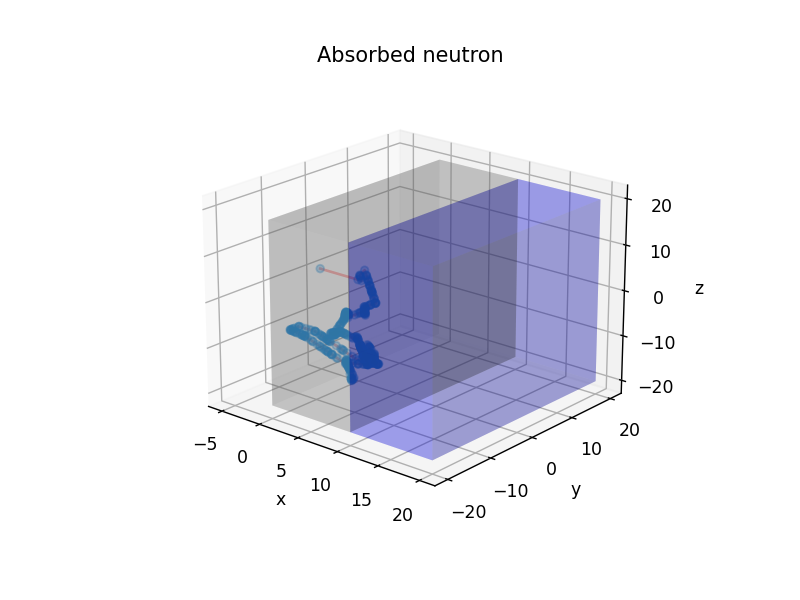

<IPython.core.display.Javascript object>


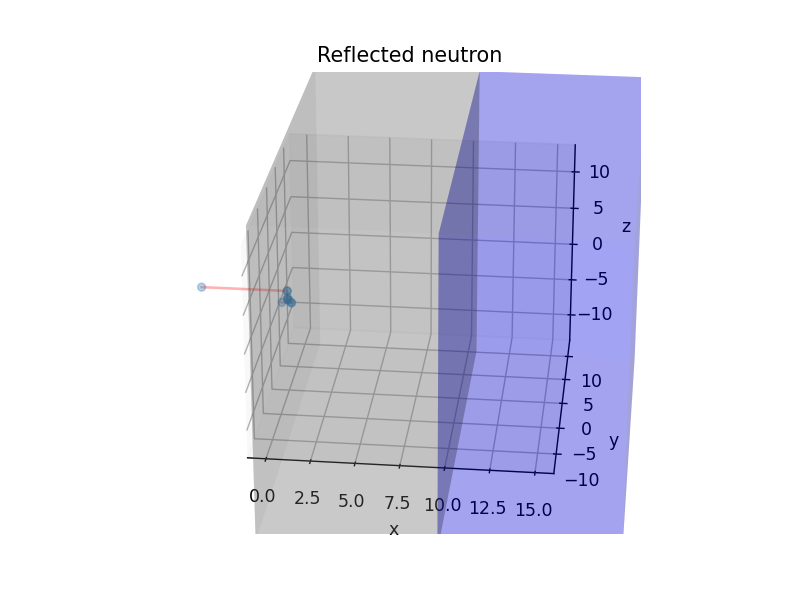

<IPython.core.display.Javascript object>


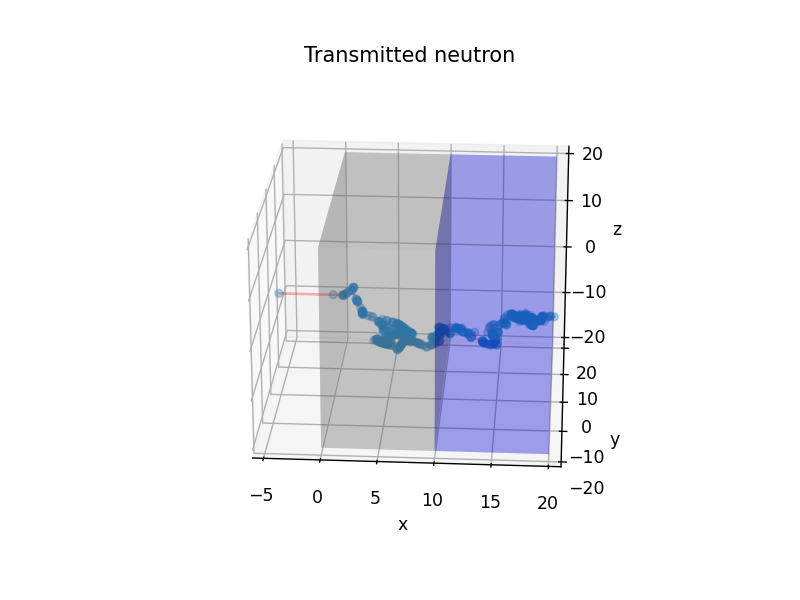

In [21]:
def woodcock_register_positions(density_1, particle_mass_1, sigma_absorb_1, sigma_scatter_1,
                                density_2, particle_mass_2, sigma_absorb_2, sigma_scatter_2):
    number_density_1 = density_1 / particle_mass_1
    sigma_total_1 = number_density_1 * (sigma_absorb_1 + sigma_scatter_1)
    # mfp_1 = 1/ sigma_total_1
    prob_absorb_1 = number_density_1 * sigma_absorb_1 / sigma_total_1
    
    number_density_2 = density_2 / particle_mass_2
    sigma_total_2 = number_density_2 * (sigma_absorb_2 + sigma_scatter_2)
    # mfp_2 = 1/ sigma_total_2
    prob_absorb_2 = number_density_2 * sigma_absorb_2 / sigma_total_2
    
    # For the case where sigma_total_2 > sigma_total_1
    sigma_total = max(sigma_total_1, sigma_total_2)
    mfp = 1 / sigma_total
    sigma_min = min(sigma_total_1, sigma_total_2)
    probability_ficticious = sigma_min / sigma_total
    
    positions = np.zeros((2, 3)) # Matrix where the coordinates are going to be registered
    positions[0, 0] = -5 # For plotting purpposes we set the neutron coming from x = -5 cm
    positions_copy = positions # Since we are going to be changing the array 'positions', we need a copy of it
   
    # Define initial spherical coordinates of direction of travel of the neutron taht we are going to be following:
    theta = np.pi
    phi = 0
    
    register_transmitted = True
    register_absorbed = True
    register_reflected = True
    counter_step = 0
    
    while register_absorbed or register_reflected or register_transmitted:
        if counter_step == 0:
            # Move in the positive x-direction and register the new (cartesian) coordinates
            delta_x = exponential_distribution(1, 0, mfp, plot=False)
            new_positions = positions[-1, :] + np.array([delta_x[0], 0, 0])
            positions = np.vstack((positions, new_positions))
            
            counter_step += 1
        
        else:
            if positions[-1, 0] < 10: # Case for which the particle is the first slab
                # Decide whether the next step is going to be ficticious or not
                random_number_ficticious = np.random.uniform() # Generate random number between 0 and 1 for ficticious step
                
                if random_number_ficticious > probability_ficticious: # Case for ficticious step
                    displacement = exponential_distribution(1, 0, mfp, plot=False) # Calculate step
                    # Transform to cartesian coordinates
                    delta_x = displacement * np.sin(theta) * np.cos(phi)
                    delta_y = displacement * np.sin(theta) * np.sin(phi)
                    delta_z = displacement * np.cos(theta)
                    new_positions = positions[-1, :] + np.array([delta_x[0], delta_y[0], delta_z[0]])
                    positions = np.vstack((positions, new_positions))
                    
                else: # Case for real step
                    # Decide if the neutron is going to be absorbed or scattered
                    random_number_absorb = np.random.uniform() # Generate random number between 0 and 1 for absorbption
                    if random_number_absorb < prob_absorb_1: 
                        if register_absorbed:
                            positions_absorbed = positions # Create array with the positions of the absorbed neutron
                            register_absorbed = False # Change the value of register_absorbed to False because we already have registered the positions of a absorbed neutron
                        positions = positions_copy # We set the positions array to the itinital one
                        counter_step = 0 # We consider a new particle from the beginning
                        
                    else: # Case for scattering
                        # Generate length and direction of new step
                        displacement, theta, phi = random_spherical_shell(1, mfp, plot=False, cartesian_output=False)
                        delta_x = displacement * np.sin(theta) * np.cos(phi)
                        delta_y = displacement * np.sin(theta) * np.sin(phi)
                        delta_z = displacement * np.cos(theta)
                        # Register new coordiates
                        new_positions = positions[-1, :] + np.array([delta_x[0], delta_y[0], delta_z[0]])
                        positions = np.vstack((positions, new_positions))
                    
            if positions[-1, 0] >= 10: # Case for which the particle is the second slab 
                # Decide if the neutron is going to be absorbed or scattered
                random_number_absorb = np.random.uniform() # Generate random number between 0 and 1 for absorbption
                if random_number_absorb < prob_absorb_2: 
                    if register_absorbed:
                        positions_absorbed = positions # Create array with the positions of the absorbed neutron
                        register_absorbed = False # Change the value of register_absorbed to False because we already have registered the positions of a absorbed neutron
                    positions = positions_copy # We set the positions array to the itinital one
                    counter_step = 0 # We consider a new particle from the beginning
                
                else: # Case for scattering
                    # Generate length and direction of new step
                    displacement, theta, phi = random_spherical_shell(1, mfp, plot=False, cartesian_output=False)
                    delta_x = displacement * np.sin(theta) * np.cos(phi)
                    delta_y = displacement * np.sin(theta) * np.sin(phi)
                    delta_z = displacement * np.cos(theta)
                    # Register new coordiates
                    new_positions = positions[-1, :] + np.array([delta_x[0], delta_y[0], delta_z[0]])
                    positions = np.vstack((positions, new_positions))
            
            counter_step += 1
    
        if positions[-1, 0] < 0:
            if register_reflected:
                positions_reflected = positions # Create array with the positions of the reflected neutron
                register_reflected = False # Change the value of register_reflected to False because we already have registered the positions of a reflected neutron
            
            positions = positions_copy # We set the positions array to the itinital one
            counter_step = 0 # We consider a new particle from the beginning
        
        if positions[-1, 0] > 20:
            if register_transmitted:
                positions_transmitted = positions # Create array with the positions of the transmitted neutron
                register_transmitted = False # Change the value of register_transmitted to False because we already have registered the positions of a transmitted neutron
        
            positions = positions_copy # We set the positions array to the itinital one
            counter_step = 0 # We consider a new particle from the beginning
        
    return positions_absorbed, positions_reflected, positions_transmitted

def plot_particle_trajectory(density_1, particle_mass_1, sigma_absorb_1, sigma_scatter_1,
                             density_2, particle_mass_2, sigma_absorb_2, sigma_scatter_2):
    positions_absorbed, positions_reflected, positions_transmitted = woodcock_register_positions(11.35, 207.2*1.66e-24, 0.158*1.13e-24, 11.221*1.13e-24,
                                                                                                  1, 18.015*1.66e-24, 0.6652*1.13e-24, 103.0*1.13e-24)
    
    fig_absorbed, ax1 = plot_slab(np.array([0, 10]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'grey')
    fig_absorbed, ax1 = plot_slab(np.array([10, 20]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'blue', existing_figure=True, input_fig=fig_absorbed, input_ax=ax1)
    ax1.scatter(positions_absorbed[:, 0], positions_absorbed[:, 1], positions_absorbed[:, 2], alpha=0.3)
    ax1.plot(positions_absorbed[:, 0], positions_absorbed[:, 1], positions_absorbed[:, 2], alpha=0.3, c='red')
    ax1.set_title('Absorbed neutron')
    
    fig_reflected, ax2 = plot_slab(np.array([0, 10]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'grey')
    fig_reflected, ax2 = plot_slab(np.array([10, 20]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'blue', existing_figure=True, input_fig=fig_reflected, input_ax=ax2)
    ax2.scatter(positions_reflected[:, 0], positions_reflected[:, 1], positions_reflected[:, 2], alpha=0.3)
    ax2.plot(positions_reflected[:, 0], positions_reflected[:, 1], positions_reflected[:, 2], alpha=0.3, c='red')
    ax2.set_title('Reflected neutron')
    
    fig_transmitted, ax3 = plot_slab(np.array([0, 10]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'grey')
    fig_transmitted, ax3 = plot_slab(np.array([10, 20]), np.array([-20, 20]), np.array([-20, 20]), 0.2, 'blue', existing_figure=True, input_fig=fig_transmitted, input_ax=ax3)
    ax3.scatter(positions_transmitted[:, 0], positions_transmitted[:, 1], positions_transmitted[:, 2], alpha=0.3)
    ax3.plot(positions_transmitted[:, 0], positions_transmitted[:, 1], positions_transmitted[:, 2], alpha=0.3, c='red')
    ax3.set_title('Transmitted neutron')
    
plot_particle_trajectory(density_lead, particle_mass_lead, sigma_absorb_lead, sigma_scatter_lead,
                         density_water, particle_mass_water, sigma_absorb_water, sigma_scatter_water)

If we plot the results as above, we can see the same as in section 2: reflections tend to occur near the first wall and transmissions are very convoluted.